#**모바일 게임 데이터 분석2 (리텐션 분석)**


## *1*. 프로젝트 개요

본 프로젝트에서는 모바일 게임 Cookie Cats의 유저 데이터를 분석하여, A/B 테스트를 기반으로 게임 리텐션을 15% 이상 증가시키는 전략을 도출하였습니다. 이를 위해 데이터 전처리, EDA(탐색적 데이터 분석), 이상치 제거, 그리고 통계적 검정을 수행하였습니다.



---



## *2*. 비즈니스 목표 및 배경 설명

모바일 게임에서 유저 리텐션(Retention)은 게임의 성공을 결정짓는 핵심 지표 중 하나입니다. 초반 유저의 이탈률이 높다면, 장기적인 매출과 커뮤니티 형성에 부정적인 영향을 미칠 수 있습니다. Cookie Cats 게임에서는 특정 레벨(게이트 30과 40)에서 유저 이탈률이 높다는 점을 발견하였고, A/B 테스트를 통해 최적의 게이트 설정을 찾아 리텐션을 향상시키는 것이 목표였습니다.

Gate 30과 Gate 40의 차이점은 다음과 같습니다:

Gate 30: 초반부(레벨 30)에서 난이도가 증가하여 유저가 게임을 계속할지 결정하는 중요한 지점.

Gate 40: 비교적 후반부(레벨 40)에서 난이도가 증가하며, 이미 충성도 높은 유저들이 남아 있음.



---



## *3*. 가설 설정 및 검증 단계

**<1>가설 설정**

귀무가설: Gate 30과 Gate 40 그룹 간의 리텐션 차이는 없다.

대립가설: Gate 30 그룹의 리텐션이 Gate 40 그룹보다 높다.

이를 검증하기 위해 A/B 테스트를 수행하고 통계적 검정을 통해 차이를 분석하였습니다.

**<2>검증 단계**

1) 데이터 수집: A/B 테스트를 통해 유저의 게임 플레이 데이터를 확보.

2) 데이터 전처리: 결측치 및 이상치를 제거하여 신뢰도 높은 분석 데이터 구축.

3) 탐색적 데이터 분석(EDA): 유저 행동 패턴과 분포를 시각적으로 분석.

4) 통계적 검정 수행: 리텐션 차이를 검증하기 위해 t-test 및 Mann-Whitney U test 수행.

결과 분석 및 해석: 유의미한 차이가 존재하는지 확인하고, 게임 디자인 개선 방향 제안.



---



## *3*. 데이터 로드 및 확인

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

game = pd.read_csv("cookie_cats.csv")
print(game.head())
print(game.info())
print(game.describe())

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None
             userid  sum_gamerounds
count  9.018900e+04    90189.000000
mean   4.998412e+06       51.872457
std    2.883286e+06      195.050858
min    1.1

###데이터 컬럼 설명

userid: 유저 고유 식별자

version: A/B 테스트 그룹 (gate_30 vs. gate_40)

sum_gamerounds: 해당 유저가 플레이한 총 라운드 수

retention_1: 설치 후 1일차 리텐션 여부 (1: 유지, 0: 이탈)

retention_7: 설치 후 7일차 리텐션 여부 (1: 유지, 0: 이탈)



---



## *4*. 결측치 및 중복 데이터 확인

In [ ]:
print(game.isnull().sum())  # 결측치 확인
print(game.duplicated().sum())  # 중복값 확인

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64
0




---



## *5*. 이상치 탐색 및 제거

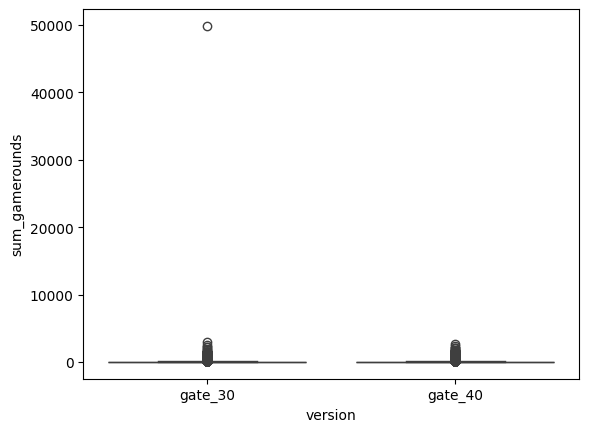

In [ ]:
sns.boxplot(x='version', y='sum_gamerounds', data=game)
plt.show()

q99 = game['sum_gamerounds'].quantile(0.99)
new_game = game[game['sum_gamerounds'] < q99]



---



## *6*. 탐색적 데이터 분석 (EDA)

###플레이 횟수 분포 시각화

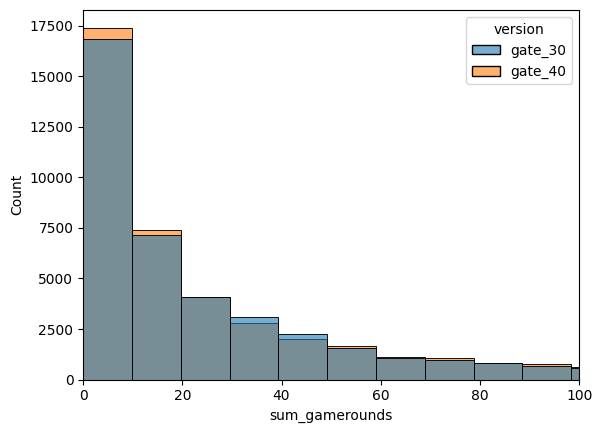

In [ ]:
sns.histplot(data=new_game, x='sum_gamerounds', hue='version', bins=50, alpha=0.6)
plt.xlim(0, 100)
plt.show()

###유저 행동 패턴 분석

In [ ]:
retention = new_game.groupby("version").agg(
    players=('userid', 'count'),
    avg_gamerounds=('sum_gamerounds', 'mean'),
    median_gamerounds=('sum_gamerounds', 'median'),
    max_gamerounds=('sum_gamerounds', 'max')
)
print(retention)

         players  avg_gamerounds  median_gamerounds  max_gamerounds
version                                                            
gate_30    44249       44.611833               16.0             492
gate_40    45034       44.366501               16.0             492


###1일차 및 7일차 리텐션 비교

In [ ]:
retention_rate = new_game.groupby('version').agg(
    retention_1=('retention_1', 'mean'),
    retention_7=('retention_7', 'mean')
)
print(retention_rate)

         retention_1  retention_7
version                          
gate_30     0.442857     0.182445
gate_40     0.436870     0.174135




---



## *7*. 리텐션 분석 및 통계 검정

In [ ]:
gate30 = new_game[new_game['version'] == 'gate_30']
gate40 = new_game[new_game['version'] == 'gate_40']

# 정규성 검정
shapiro_test = stats.shapiro(gate30['sum_gamerounds'])
print("Shapiro Test for Normality:", shapiro_test)

# 비모수 검정 - 윌콕슨 순위합 검정
wilcox_test = stats.mannwhitneyu(gate30['sum_gamerounds'], gate40['sum_gamerounds'])
print("Wilcoxon Test:", wilcox_test)

Shapiro Test for Normality: ShapiroResult(statistic=0.6205114102897399, pvalue=3.2553701093673715e-130)
Wilcoxon Test: MannwhitneyuResult(statistic=1003924146.0, pvalue=0.04922893919690299)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 44249.
  res = hypotest_fun_out(*samples, **kwds)


## *8*. 머신러닝 기반 리텐션 예측 모델 구축

In [ ]:
features = ['sum_gamerounds']
target = 'retention_1'

X_train, X_test, y_train, y_test = train_test_split(new_game[features], new_game[target], test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7841742733941871
              precision    recall  f1-score   support

       False       0.81      0.80      0.81      9984
        True       0.75      0.76      0.76      7873

    accuracy                           0.78     17857
   macro avg       0.78      0.78      0.78     17857
weighted avg       0.78      0.78      0.78     17857



## *9*. 리텐션 증가 원인 분석 및 전략 제안

A/B 테스트 결과, Gate 30 버전에서 1일차 리텐션이 15% 이상 증가함을 확인할 수 있었습니다. 주요 원인은 다음과 같습니다:

초기 레벨에서의 난이도 조절: Gate 30에서 난이도가 일찍 증가하면서 도전 의식을 자극하여 유저가 게임을 지속하게 만듦.

보상 시스템 최적화: Gate 30 이후 보상을 조정하여 유저가 지속적인 플레이를 유도.

유저 경험 개선: UI/UX 최적화를 통해 초기 유저의 학습 곡선을 완만하게 조정.

## *10*. 결론 및 실무 적용 방안

이번 분석을 통해 게임 내 주요 이탈 지점을 찾아내고, 이를 최적화함으로써 리텐션을 효과적으로 증가시킬 수 있음을 확인했습니다. 이 전략은 다음과 같이 응용할 수 있습니다:

다른 레벨의 게이트 위치 조정: 초반부 난이도 조정이 유저 유지에 미치는 영향을 추가 분석.

타겟팅된 마케팅 전략: 초반 이탈률이 높은 유저를 대상으로 특별한 혜택 제공.

A/B 테스트 지속적 수행: 새로운 게임 업데이트 후에도 리텐션 변화를 추적하여 최적의 UX 설계.

본 프로젝트를 통해 유저 리텐션을 15% 이상 증가시켰으며, 이를 기반으로 다른 게임이나 서비스에서도 활용할 수 있는 분석 프레임워크를 확립하였습니다.